Эти заметки я поначалу делал для себя, а потом решил выложить их в качестве туториала - будут рад, если кому-то это покажется полезным или интересным. 
Все дальнейшие примеры рассмотрены на примере бесплатной СУБД Oracle Database 11g Express Edition, которую можно найти на [oracle.com](http://www.oracle.com/technetwork/database/database-technologies/express-edition/downloads/index.html) и при желании скачать, предварительно зарегистрировавшись. 
В заключении рассмотрены вопросы быстродействия при загрузке данных из pandas.DataFrame в БД Oracle (проведено сравнение с загрузкой в MS SQL Server, данные и программный код для сравнения взяты из [тюториала Олега (@Oleg)](https://github.com/Yorko/mlcourse_open/blob/master/jupyter_russian/tutorials/Pandas_and_SQL_server_oleg.ipynb) с разрешения автора) 

# Oracle и macOS

Прежде всего хотелось бы рассмотреть один из способов установки сервера Oracle в macOS. Пользователи других ОС могут переходить к следующему пункту - для них установка OracleXE не должна вызвать особых сложностей. 

Для начала понадобится скачать и установить Docker — программное обеспечение для автоматизации развёртывания и управления приложениями в виртуальной среде. Отмечу, что данный вариант не требователен к ресурсам и подойдет для Mac, выпущеных не ранее 2010 года и всё ещё работающих на OS X El Capitan 10.11 или более новых версиях macOs.  

Скачать стабильную сборку Docker можно [по ссылке](https://download.docker.com/mac/stable/Docker.dmg). Устанавливаем приложение стандартым способом и запускаем.

Далее необходимо использовать официальные Docker images для Oracle Software на github - клонируем git репозиторий командой: 

**git clone https://github.com/oracle/docker-images.git** 



После чего скачаем [OracleXE для Linux](http://www.oracle.com/technetwork/database/database-technologies/express-edition/downloads/index.html)
и скопируем zip-архив OracleXE в каталог ../docker-images/OracleDatabases/dockerfiles/11.2.0.2 клонированного git репозитория:

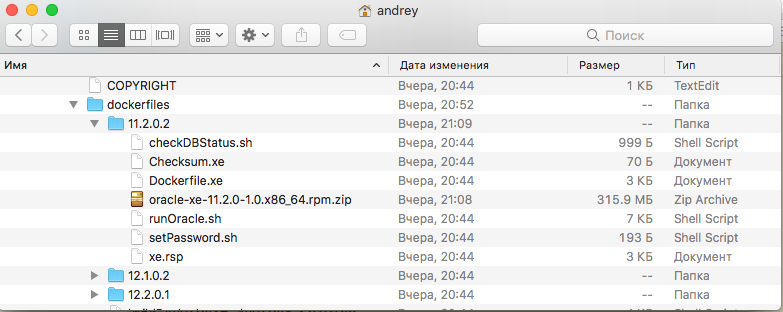

Билдим Oracle XE Docker Image запуском скрипта из каталога dockerfiles: 

**./buildDockerImage.sh -v 11.2.0.2 -x -i** 

Убедимся, что образ Oracle создан - выполним команду **docker images**:


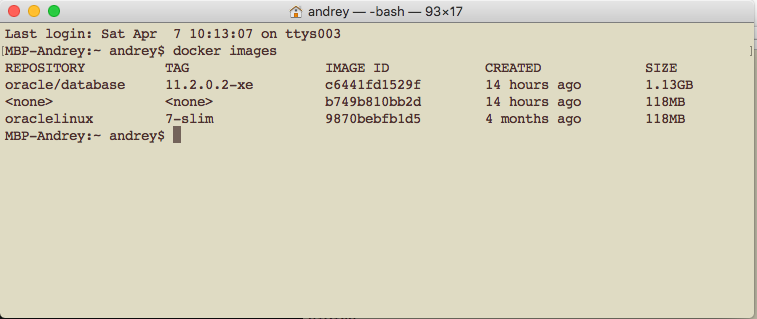

Запустим новый контейнер:

**docker run --name OracleXE --shm-size=1g -p 1521:1521 -p 8080:8080 -e ORACLE_PWD=weblogic1 oracle/database:11.2.0.2-xe** 

в результате в логах увидим

#########################

DATABASE IS READY TO USE!

#########################

(для пользователей SYS и SYSTEM установится переданный в ORACLE_PWD пароль weblogic1) 

Увидеть список запущенных контейнеров можно командой: 

**docker ps**

Остановить контейнер:

**docker stop OracleXE**

Запустить контейнер:

**docker start OracleXE**

Просмотреть логи:

**docker logs OracleXE**

Уже теперь можно скачать SQLDeveloper или Aqua Data Studio, подключиться к БД (system/weblogic1@localhost/xe) и всё должно работать, но для работы с БД в Jupyter Notebook (запуска sql*plus) необходимо установить Instant Client Package - Basic (+ Instant Client Package - SQL*Plus) [отсюда](http://www.oracle.com/technetwork/topics/intel-macsoft-096467.html)
Подробности установки описаны [здесь](https://oracle.github.io/odpi/doc/installation.html#macos)

Подробнее о работе с Docker в macOs можно почитать [на сайте](https://docs.docker.com/docker-for-mac/)

# Подключаемся к БД 

Шлюзом между базой данных и языком Python является объект **Connection**. Именно его мы создадим в первую очередь после импорта библиотеки **cx_Oracle**: вызовем метод **connect**, передав в него параметры подключения в виде строки "пользователь/пароль@хост/SID". Полученный объект Connection будет в дальнейшем использоваться при создании курсоров для доступа к БД. 

Все действия будем проводить на демонстрационной БД, которая идет в составе OracleXE, предварительно разблокировав учетную запись пользователя HR - владельца схемы HR.

При успешном подключении будет выведен номер версии БД (атрибут **version** объекта Connection).

In [132]:
import cx_Oracle
db = cx_Oracle.connect('system/weblogic1@localhost/xe')
cursor = db.cursor()
cursor.execute('ALTER USER HR ACCOUNT UNLOCK IDENTIFIED BY HR')
db.close()
db = cx_Oracle.connect('HR/HR@localhost/xe')
print (db.version)

11.2.0.2.0


# Работаем с БД

Рассмотрим способы получения данных из таблиц БД. Все они основаны на работе с курсорами. Под курсором в Oracle понимается получаемый при выполнении запроса результирующий набор и связанный с ним указатель текущей записи. Простым программам достаточно одного курсора, который можно использовать снова и снова, для более крупных проектов могут потребоваться несколько отдельных курсоров. В библиотеке cx_Oracle курсор создается методом cursor() объекта Connection. 

Можно выделить 3 этапа обработки операторов SQL, каждому из которых соответствуют методы cx_Oracle:

1) Разбор (parsing)

2) Выполнение (execute)

3) Извлечение (fetch)


**Первый этап** не является обязательным, т.к. все операторы автоматически парсятся на этапе выполнения. Метод parsing() можно использовать для предварительной проверки корректности оператора SQL (в случае ошибки возникнет исключение DatabaseError с соответствующим сообщением): 

In [133]:
cursor = db.cursor()
cursor.parse('select * from departments order by department_id') 

**Второй этап** - непосредственное выполнение оператора SQL - представлен метод курсора execute(). После выполнения запроса к таблице БД, удобно использовать курсор в качестве итератора в цикле for для последовательного доступа к возвращаемым записям, которые представлены в виде набор кортежей (тюплов или таплов - кому как нравится). Каждому кортежу соответствует одна запись в таблице hr.departments. 

In [134]:
cursor.execute('select * from departments order by department_id')
for result in cursor:
    print(result)

(10, 'Administration', 200, 1700)
(20, 'Marketing', 201, 1800)
(30, 'Purchasing', 114, 1700)
(40, 'Human Resources', 203, 2400)
(50, 'Shipping', 121, 1500)
(60, 'IT', 103, 1400)
(70, 'Public Relations', 204, 2700)
(80, 'Sales', 145, 2500)
(90, 'Executive', 100, 1700)
(100, 'Finance', 108, 1700)
(110, 'Accounting', 205, 1700)
(120, 'Treasury', None, 1700)
(130, 'Corporate Tax', None, 1700)
(140, 'Control And Credit', None, 1700)
(150, 'Shareholder Services', None, 1700)
(160, 'Benefits', None, 1700)
(170, 'Manufacturing', None, 1700)
(180, 'Construction', None, 1700)
(190, 'Contracting', None, 1700)
(200, 'Operations', None, 1700)
(210, 'IT Support', None, 1700)
(220, 'NOC', None, 1700)
(230, 'IT Helpdesk', None, 1700)
(240, 'Government Sales', None, 1700)
(250, 'Retail Sales', None, 1700)
(260, 'Recruiting', None, 1700)
(270, 'Payroll', None, 1700)


**Третий этап** - извлечение данных - не является обязательным, используется только для запросов (поскольку операторы DDL и DCL не возвращают результаты) и представлен несколькими fetch-методами. На курсоре, который не выполнил запрос, fetch-методы вызовут исключение InterfaceError. 

Метод курсора **fetchone()** возвращает одну текущую запись из результирующего набора данных. При дальнейших вызовах этого метода будут возвращаться следующие записи последовательно. Eсли все данные из курсора были ранее "извлечены", метод вернёт None.

In [135]:
cursor.execute('select * from departments order by department_id')             
row = cursor.fetchone()
print(row)
row = cursor.fetchone()
print(row)

(10, 'Administration', 200, 1700)
(20, 'Marketing', 201, 1800)


Метод **fetchmany()** возвращает список кортежей - ровно столько записей, сколько было передано в параметре **numRows** (или пустой список, если все записи из курсора были выбраны ранее):

In [136]:
from pprint import pprint
res = cursor.fetchmany(numRows=3)
pprint(res)

[(30, 'Purchasing', 114, 1700),
 (40, 'Human Resources', 203, 2400),
 (50, 'Shipping', 121, 1500)]


Метод **fetchall()** возвращает все оставшиеся записи открытого курсора:

In [137]:
res = cursor.fetchall()
pprint(res)

[(60, 'IT', 103, 1400),
 (70, 'Public Relations', 204, 2700),
 (80, 'Sales', 145, 2500),
 (90, 'Executive', 100, 1700),
 (100, 'Finance', 108, 1700),
 (110, 'Accounting', 205, 1700),
 (120, 'Treasury', None, 1700),
 (130, 'Corporate Tax', None, 1700),
 (140, 'Control And Credit', None, 1700),
 (150, 'Shareholder Services', None, 1700),
 (160, 'Benefits', None, 1700),
 (170, 'Manufacturing', None, 1700),
 (180, 'Construction', None, 1700),
 (190, 'Contracting', None, 1700),
 (200, 'Operations', None, 1700),
 (210, 'IT Support', None, 1700),
 (220, 'NOC', None, 1700),
 (230, 'IT Helpdesk', None, 1700),
 (240, 'Government Sales', None, 1700),
 (250, 'Retail Sales', None, 1700),
 (260, 'Recruiting', None, 1700),
 (270, 'Payroll', None, 1700)]


Обычно используется тот или иной fetch-метод - в зависимости от дальнейших действий над возвращаемыми данными, либо записи последовательно обрабатываются в цикле, когда курсор служит итератором. 

Если в курсоре используется запрос, то атрибут **description** отображает структуру запрашиваемых данных: выдается список кортежей, где каждый кортеж состоит из имени столбца, типа столбца, видимого размера, внутреннего размера, точности, масштаба и возможно ли null-значение.  

In [138]:
pprint(cursor.description)

[('DEPARTMENT_ID', <class 'cx_Oracle.NUMBER'>, 5, None, 4, 0, 0),
 ('DEPARTMENT_NAME', <class 'cx_Oracle.STRING'>, 30, 30, None, None, 0),
 ('MANAGER_ID', <class 'cx_Oracle.NUMBER'>, 7, None, 6, 0, 1),
 ('LOCATION_ID', <class 'cx_Oracle.NUMBER'>, 5, None, 4, 0, 1)]


Как известно, в запросах часто используются условия. В качестве подставляемых параметров запроса рекомендуется использовать связываемые переменные. cx_Oracle поддерживает передачу связываемых переменных по имени (query1 и query2) или по позиции (query3). 

In [139]:
named_params = {'dept_id':50, 'sal':8000}

query1 = cursor.execute('SELECT FIRST_NAME, LAST_NAME FROM hr.employees WHERE department_id = :dept_id AND salary > :sal', 
                        named_params)
pprint(query1.fetchall())

query2 = cursor.execute('SELECT FIRST_NAME, LAST_NAME FROM hr.employees WHERE department_id = :dept_id AND salary > :sal', 
                        dept_id=50, sal=8000)
pprint(query2.fetchall())

query3 = cursor.execute('SELECT * FROM hr.locations WHERE country_id=:1 AND city=:2', ('US', 'Seattle'))
pprint(query3.fetchall())

[('Adam', 'Fripp')]
[('Adam', 'Fripp')]
[(1700, '2004 Charade Rd', '98199', 'Seattle', 'Washington', 'US')]


При работе со связываемыми переменными можно сначала подготовить (**prepare()**) запрос, а потом выполнить его. Подготовленные операторы можно выполнять многократно.

In [140]:
cursor.prepare('SELECT * FROM jobs WHERE min_salary > : min')
r = cursor.execute (None, {'min': 9000})
pprint(r.fetchall())

[('AD_PRES', 'President', 20080, 40000),
 ('AD_VP', 'Administration Vice President', 15000, 30000),
 ('SA_MAN', 'Sales Manager', 10000, 20080)]


В cx_Oracle существует возможность пакетной обработки операторов SQL при помощи метода **executemany()**, что часто применяется при добавлении данных в таблицы. Вначале необходимо подготовить последовательность (в нашем случае - список), затем передать в качестве параметра методу executemany(). Создадим таблицу, заполним её данными при помощи executemany(), подсчитаем количество строк, а потом удалим таблицу:

In [141]:
create_table = """
CREATE TABLE python_modules (
module_name VARCHAR2(50) NOT NULL,
file_path VARCHAR2(300) NOT NULL
)
"""
cursor.execute(create_table)

from sys import modules
M = []
for m_name, m_info in modules.items():
    try:
        M.append((m_name, m_info.__file__))
    except AttributeError:
        pass

cursor.prepare("INSERT INTO python_modules(module_name, file_path) VALUES (:1, :2)")
cursor.executemany(None, M)
db.commit()
r = cursor.execute("SELECT COUNT(*) FROM python_modules")
print (cursor.fetchone())  

cursor.execute("DROP TABLE python_modules PURGE")

(1622,)


# Работаем с Pandas

Библиотека Pandas позволяет загружать данные из таблиц Oracle непосредственно в DataFrame, для чего используется метод **read_sql()**:

In [142]:
import pandas as pd
df_ora = pd.read_sql('select * from employees', con=db)    
df_ora[:5]

,EMPLOYEE_ID,FIRST_NAME,LAST_NAME,EMAIL,PHONE_NUMBER,HIRE_DATE,JOB_ID,SALARY,COMMISSION_PCT,MANAGER_ID,DEPARTMENT_ID
0,100,Steven,King,SKING,515.123.4567,2003-06-17,AD_PRES,24000.0,NaN,NaN,90.0
1,101,Neena,Kochhar,NKOCHHAR,515.123.4568,2005-09-21,AD_VP,17000.0,NaN,100.0,90.0
2,102,Lex,De Haan,LDEHAAN,515.123.4569,2001-01-13,AD_VP,17000.0,NaN,100.0,90.0
3,103,Alexander,Hunold,AHUNOLD,590.423.4567,2006-01-03,IT_PROG,9000.0,NaN,102.0,60.0
4,104,Bruce,Ernst,BERNST,590.423.4568,2007-05-21,IT_PROG,6000.0,NaN,103.0,60.0


При этом также можно использовать связываемые переменные в запросах:

In [143]:
df_ora = pd.read_sql('select * from hr.employees where EMPLOYEE_ID=:myempno', params={"myempno":110}, con=db) 
df_ora

,EMPLOYEE_ID,FIRST_NAME,LAST_NAME,EMAIL,PHONE_NUMBER,HIRE_DATE,JOB_ID,SALARY,COMMISSION_PCT,MANAGER_ID,DEPARTMENT_ID
0,110,John,Chen,JCHEN,515.124.4269,2005-09-28,FI_ACCOUNT,8200.0,None,108,100


И конечно же всеми любимая визуализация данных: достаточно одного взгляда на график, чтобы оценить уровень зарплаты сотрудников

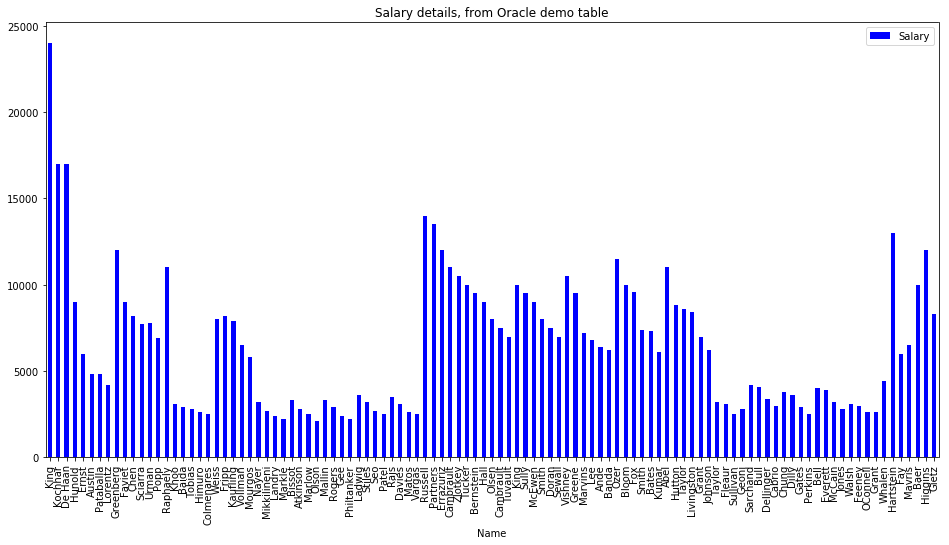

In [144]:
import seaborn as sns
%matplotlib inline
df_ora = pd.read_sql('select LAST_NAME "Name", SALARY "Salary" from employees', con=db)    
df_ora.plot(x='Name', y='Salary', title='Salary details, from Oracle demo table', 
            figsize=(16, 8), kind='bar', color='blue')


# Оценка быстродействия при загрузке данных в БД

Для загрузки данных в БД можно использовать стандартный метод Pandas.DataFrame **to_sql()**. В параметре con этого метода передается объект **Engine** библиотеки **SQLAlchemy**, поэтому сначала импортируем эту библиотеку, определим параметры подключения к БД, создадим объект **Engine**:

In [145]:
from sqlalchemy import  create_engine

#######################################################
### DB connection strings config
#######################################################
tns = """
  (DESCRIPTION =
    (ADDRESS = (PROTOCOL = TCP)(HOST = 0.0.0.0)(PORT = 1521))
    (CONNECT_DATA =
      (SERVER = DEDICATED)
      (SERVICE_NAME = XE)
    )
  )
"""

usr = "HR"
pwd = "HR"

engine = create_engine('oracle+cx_oracle://%s:%s@%s' % (usr, pwd, tns))

Чтобы было с чем сравнивать, я решил воспользоваться прекрасным примером из [тюториала Олега (@Oleg)](https://github.com/Yorko/mlcourse_open/blob/master/jupyter_russian/tutorials/Pandas_and_SQL_server_oleg.ipynb). Следующие пять ячеек заимствованы мной у него практически без изменений, за что ему огромное спасибо). Предварительно нужно скачать файлы [excel](https://drive.google.com/open?id=1UlcTpCWSDMVirX8YU-GOuYKkN2dOdXym) в подкаталоги Production и Prices. В результате будут сформированы 2 датафрейма: df_prices с даннами о ценах на электричество (966840 строк) и df_production с данными о плановом производстве электричества (179760 строк)

In [146]:
import os

path_production = r'Production'
path_prices = r'Prices'
list_files_production = os.listdir(path_production)
list_files_prices = os.listdir(path_prices)

files_production = [f for f in list_files_production if f[-3:] == 'xls']
files_prices = [f for f in list_files_prices if f[-3:] == 'xls']

In [147]:
# Функция предобработки файлов с ценами
def Prices_preprocessing(path, f):
    df_list = [] ## list с DataFrame по каждому часу
    for i in range(24):
        df = pd.read_excel(path + '//' + f, sheet_name = i) # Считываем файл в DataFrame
        df.drop([0, 1], inplace = True) # Вырезаем первые две строки, не содержащие ничего полезного
        df.drop(df.columns[[1, 2, 3, 5]], axis=1, inplace=True) # Удаляем лишние столбцы, оставляем
        df.columns = ['ID_node', 'price'] # Для красоты переименуем столбцы с ID узлов и ценами 
        
        df['_datetime'] = f[:8] # Вырезаем из названия дату
        df['_datetime'] = df['_datetime'].apply(lambda x: datetime.strptime(x, '%Y%m%d').replace(hour=i))
        df_list.append(df)
    df = pd.concat(df_list, axis=0, ignore_index=True) # Соединим данные с разных страниц в один DataFrame
    df.fillna(0, inplace=True) # Заполним "дырки" нулями
    return (df)

In [148]:
import time
from datetime import datetime
# Соединение данных в один DataFrame
start = time.time()
df_prices = []
for f in files_prices:
    df_prices.append(Prices_preprocessing(path_prices, f))
df_prices = pd.concat(df_prices, axis=0, ignore_index=True)

time_prices_preprocessing = time.time()-start
print('Time of Prices preprocessing = ', round(time_prices_preprocessing, 1))

Time of Prices preprocessing =  883.0


In [149]:
def func(x):
    return datetime.strptime(x[0], '%Y%m%d').replace(hour=int(x[1]))
# Функция предобработки данных по объёму производства
def Production_preprocessing(path, f):
    df = pd.read_excel(path+'//' + f)
    df.drop(df.columns[[1, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 18, 19, 21, 22, 24, 25, 27, 28, 30, 31, 33, 34,
                       36, 37, 39, 40, 42, 43, 45, 46, 48, 49, 51, 52, 54, 55, 57, 58, 60, 61, 63, 64, 66, 67, 
                       69, 70, 72, 73, 75, 76, 77, 78]], axis=1, inplace=True) # Вырезаем ненужные столбцы
    df.drop([0, 1, 2, 3, 4, 5], inplace=True) # Отрезаем верхние лишние строки
    df.drop(df.tail(1).index, inplace=True) # Отрезаем строку "Итого"
    df.columns = ['ID_unit', 'ID_node']+[x for x in range(24)] # Переименуем столбцы, в том числе данным по производству дадим номер соответствующего часа
    df['_datetime'] = f[:8] # Вырезаем из названия дату
    df = pd.melt(df, id_vars = ['ID_unit', 'ID_node', '_datetime'], value_vars = [x for x in range(24)]) # Превратим данные из столбцов по часам в строки (unpivot)
    df.rename(columns = {'value': 'production', 'variable': 'hour'}, inplace=True)
    df['_datetime'] = df[['_datetime', 'hour']].apply(func, axis=1) # Склеиваем дату и время
    df.drop(['hour'], axis=1, inplace=True) # Убираем ненужный уже столбец "hour"
    return df

In [150]:
start = time.time()
df_production = []
for f in files_production:
    df_production.append(Production_preprocessing(path_production, f))
df_production = pd.concat(df_production, axis=0, ignore_index=True)

time_production_preprocessing = time.time()-start
print('Time of Production preprocessing = ', round(time_production_preprocessing, 1))

Time of Production preprocessing =  85.2


Ноутбук у меня старенький, поэтому препроцессинг занял больше времени, чем у Олега. Вполне возможно, что и загрузка данных отнимет немало времени, ведь и установка Oracle в виртуальном контейнере Докера, как будто бы не должна способствовать быстродействию...

В начале используем **первый способ** загрузки - с помощью команды **Insert**:

In [151]:
#cursor.execute('drop table Production purge')

create_table = """
CREATE TABLE Production (
ID_unit NUMBER(20) NOT NULL,
ID_node NUMBER(20) NOT NULL,
datetime DATE NOT NULL,
production NUMBER(30) NOT NULL
)
"""
cursor.execute(create_table)

In [152]:
start = time.time()

cursor.prepare("INSERT INTO Production VALUES (:1, :2, :3, :4)")
cursor.executemany(None, df_production.values.tolist())
db.commit()

time_production_commit = time.time()-start
print(time_production_commit)

3.0566048622131348


In [153]:
#cursor.execute('drop table Price purge')

create_table = """
CREATE TABLE Price (
ID_node NUMBER(20) NOT NULL,
price float NOT NULL,
datetime DATE NOT NULL
)
"""
cursor.execute(create_table)

In [154]:
start = time.time()

cursor.prepare("INSERT INTO Price VALUES (:1, :2, :3)")
cursor.executemany(None, df_prices.values.tolist())
db.commit()

time_price_commit = time.time()-start
print(time_price_commit)

12.772806882858276


Результаты немного удивляют - практически в 10 раз быстрее, чем на MS SQL Server. 

Проверим загрузку **вторым способом** - методом **pandas.DataFrame.to_sql()**. При его использовании не нужно создавать таблицы БД, делать Commit - всё происходит автоматически.

In [155]:
%%time 
df_production.to_sql('production2', engine, index=False, if_exists='replace')

CPU times: user 13.7 s, sys: 1.77 s, total: 15.5 s
Wall time: 19.6 s


In [156]:
%%time 
df_prices.to_sql('prices2', engine, index=False, if_exists='replace')

CPU times: user 18.1 s, sys: 1.71 s, total: 19.8 s
Wall time: 21.3 s


Вторым способом получили немного худшее быстродействие. Обратим внимание на то, что типы столбцов у создаваемых таблиц определяются автоматически на основании типов столбцов у DataFrame. В нашем примере для столбца production у результирующей таблицы выбрался тип "CLOB" (Character Large Object), работа с таким типом отрицательно сказывается на быстродействии, поэтому лучше его заменить на обычный FLOAT.

In [157]:
df_production.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179760 entries, 0 to 179759
Data columns (total 4 columns):
ID_unit       179760 non-null object
ID_node       179760 non-null object
_datetime     179760 non-null datetime64[ns]
production    179760 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 5.5+ MB


Передадим методу to_sql в параметре **dtype** требуемый тип для столбца production и повторим загрузку

In [158]:
%%time 
df_production.to_sql('production3', engine, index=False, if_exists='replace', dtype={'production': types.FLOAT})

CPU times: user 3.95 s, sys: 306 ms, total: 4.26 s
Wall time: 4.49 s


Видим, что время загрузки уменьшилось и уже сопоставимо со временем загрузки первого метода (insert)

# Графики цен и планового производства

Из любопытства посмотрим на графики цен и планового производства Саяно-Шушенской ГЭС, где плановое производство электроэнергии в первые дни 2015 года было максимальным

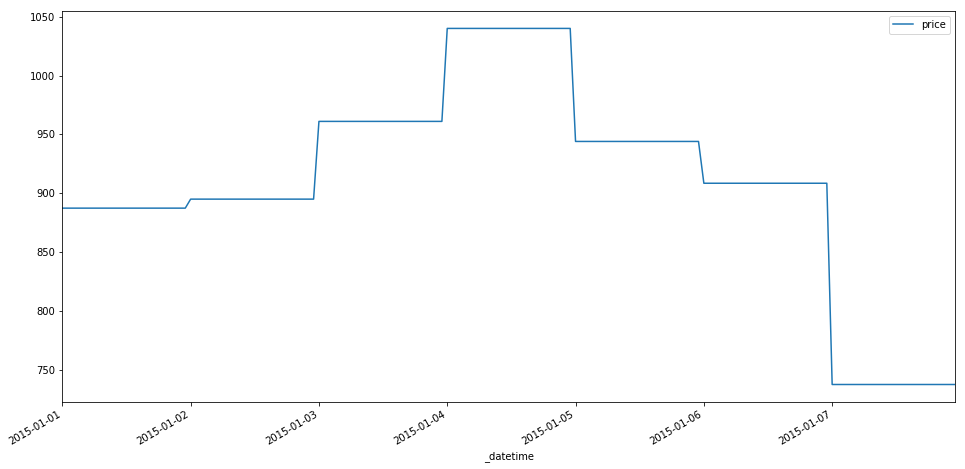

In [159]:

df_prices[df_prices['ID_node']==1001068].plot(x='_datetime', y='price', figsize=(16, 8))

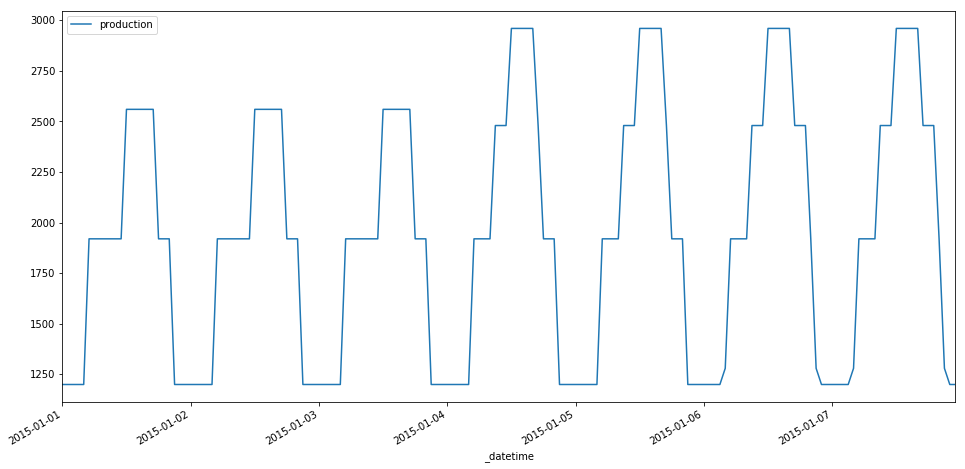

In [160]:
df_production[df_production['ID_node']==1001068].plot(x='_datetime', y='production', figsize=(16, 8))

И на графики ТЭЦ ОАО "ППГХО" в Забайкальском крае с самой дешевой ценой в первые дни 2015 года

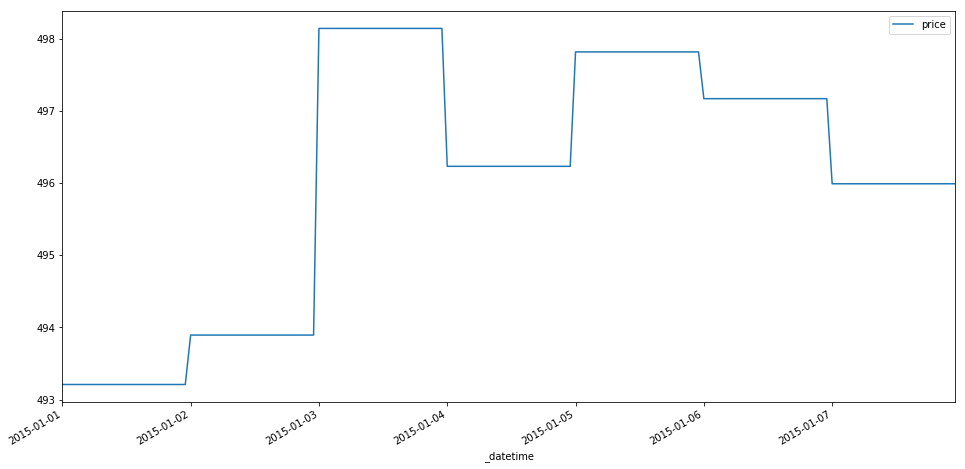

In [161]:
df_prices[df_prices['ID_node']==1001163].plot(x='_datetime', y='price', figsize=(16, 8))

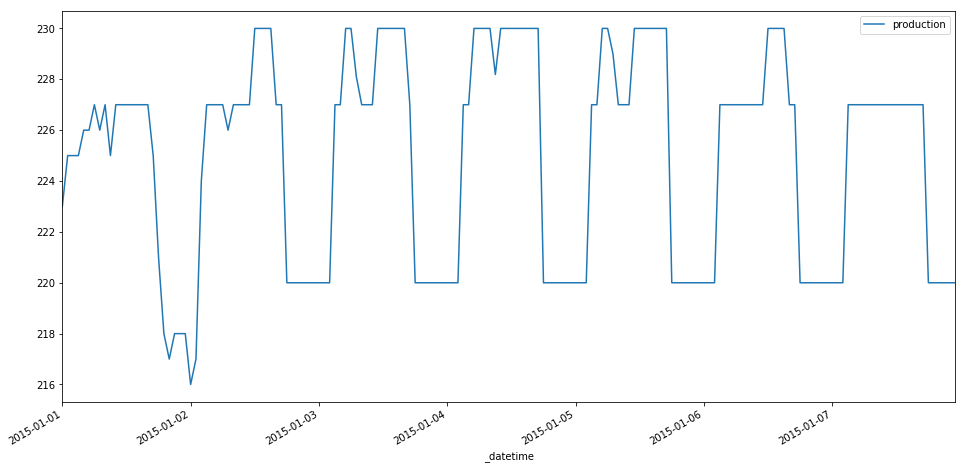

In [162]:
df_production[df_production['ID_node']==1001163].plot(x='_datetime', y='production', figsize=(16, 8))

Ну и просто цены и плановое производство электричества в масштабах страны, так сказать:

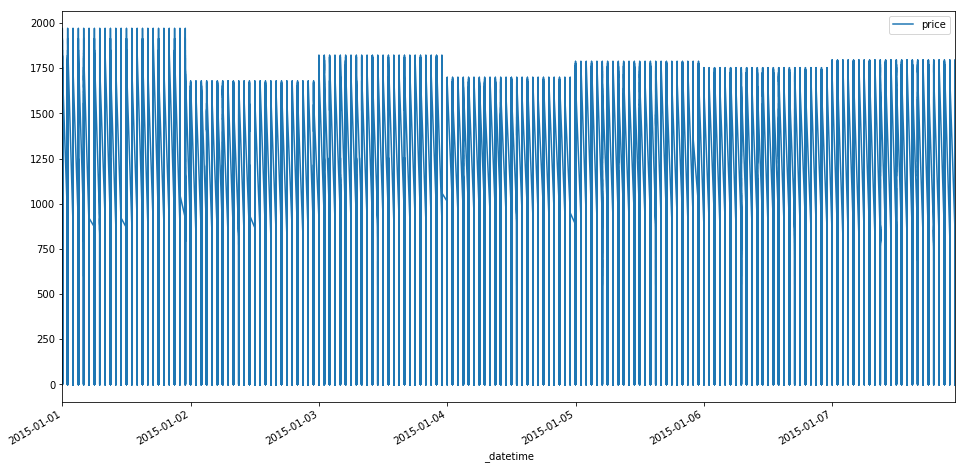

In [163]:
df_prices.plot(x='_datetime', y='price', figsize=(16, 8))

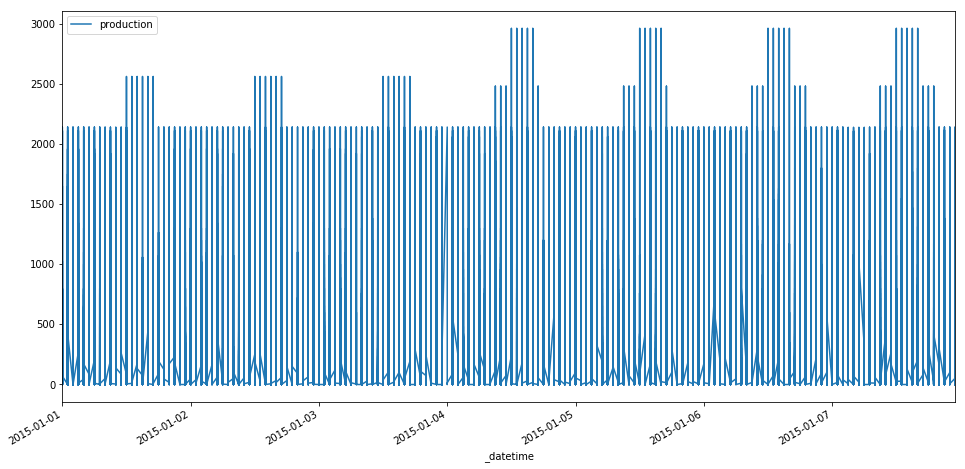

In [164]:
df_production.plot(x='_datetime', y='production', figsize=(16, 8))

В конце работы рекомендуется закрывать открытые курсоры и подключения к БД (а также выключать компьютеры с целью экономии электроэнергии)

In [165]:
cursor.close()
db.close()

In [ ]:
!sudo shutdown